In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics as stats
import numpy as np 
import os

#presidential
pres_county = pd.read_csv("data/president_county_candidate.csv")

#senate
senate_county = pd.read_csv("data/senate_county.csv")
senate_county_candidate = pd.read_csv("data/senate_county_candidate.csv")
senate_state = pd.read_csv("data/senate_state.csv")

#population
state_pop = pd.read_csv("data/state_population.csv") 
#taken from https://data.census.gov/table/DECENNIALCD1182020.P1?q=Population+Total
county_pop = pd.read_excel("data/county_pop.xlsx") 
#taken from https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html

Cleaning State and County Pop

In [2]:
state_pop = state_pop.T
state_pop.columns = state_pop.iloc[0]
state_pop = state_pop.drop(state_pop.index[0]).reset_index()
state_pop.columns = ['state', 'population']
state_pop['population'] = state_pop['population'].str.replace(',', '').astype(int)

In [3]:
county_pop_cols= county_pop.columns
county_pop_cols = county_pop_cols[:2] 
#only keep first two cols
county_pop = county_pop[4:] 
#remove excess rows
county_pop = county_pop[county_pop_cols]
county_pop = county_pop.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)':'county', 'Unnamed: 1':'population'})
county_pop = county_pop.dropna()

In [4]:
county_pop['county'] = county_pop['county'].str.lstrip('.')
county_pop[['county', 'state']] = county_pop['county'].str.split(',', expand=True)
county_pop['state'] = county_pop['state'].str.strip()
county_pop['county'] = county_pop['county'].str.strip()
county_pop['county'] = county_pop['county'].str.lower()
county_pop['state'] = county_pop['state'].str.lower()
county_pop['population'] = county_pop['population'].astype('int')

### President and Voter Share

In [5]:
pres_county['county'] = pres_county['county'].str.lower()
pres_county['state'] = pres_county['state'].str.lower()
pres_county = pres_county[(pres_county['party'] == 'DEM') | (pres_county['party'] == 'REP')]

In [6]:
pres_county = pres_county.merge(county_pop, on=['county', 'state'], how='left')
pres_county = pres_county.dropna()

In [7]:
pres_county = pres_county[pres_county['county'] != 'district of columbia']
pres_county['county_total_votes'] = pres_county.groupby(['state', 'county'])['total_votes'].transform('sum')
pres_county['vote_share'] = pres_county['total_votes'] / pres_county['county_total_votes']

In [8]:
pres_county['turnout'] = pres_county['county_total_votes'] / pres_county['population']
pres_county = pres_county[pres_county['won'] == True]

In [9]:
pres_county.describe()

,total_votes,population,county_total_votes,vote_share,turnout
count,3.043000e+03,3.043000e+03,3.043000e+03,3043.000000,3043.000000
mean,3.094824e+04,1.034345e+05,4.828328e+04,0.703882,0.486714
std,9.726042e+04,3.373890e+05,1.470081e+05,0.108195,0.081826
min,6.000000e+01,6.500000e+01,6.400000e+01,0.500121,0.161668
25%,3.777000e+03,1.081800e+04,5.183000e+03,0.615371,0.433645
50%,8.336000e+03,2.531600e+04,1.194900e+04,0.708987,0.488233
75%,2.096400e+04,6.665150e+04,3.155400e+04,0.791505,0.538552
max,3.028885e+06,1.001740e+07,4.174415e+06,0.968864,0.984615


Plotting Relationships

Figure 1. Vote Share vs. Voter Turnout by Party (Presidential Elections)

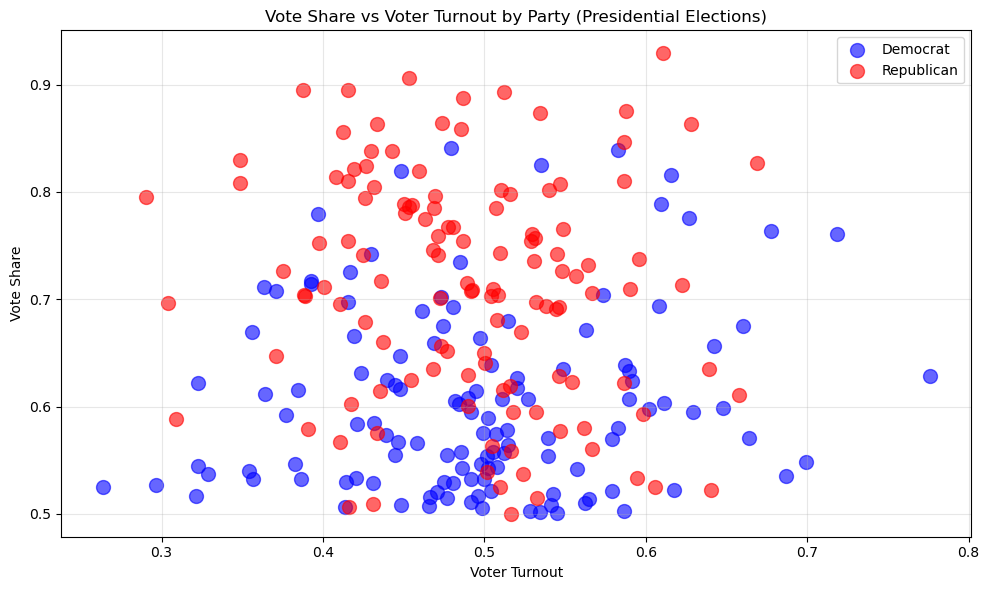

In [10]:
plt.figure(figsize=(10, 6))

dem_data = pres_county[pres_county['party'] == 'DEM'].sample(n=125, random_state=42)
rep_data = pres_county[pres_county['party'] == 'REP'].sample(n=125, random_state=42)

plt.scatter(dem_data['turnout'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turnout'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Vote Share vs Voter Turnout by Party (Presidential Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 2. Average Voter Turnout by Party (Counties Won)

/var/folders/25/_y0g0nxj2lq3862bk0gkwb580000gn/T/ipykernel_96080/1150895156.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_turnout_by_party = pres_county.groupby('party').apply(lambda x: np.average(x['turnout'], weights=x['population']))


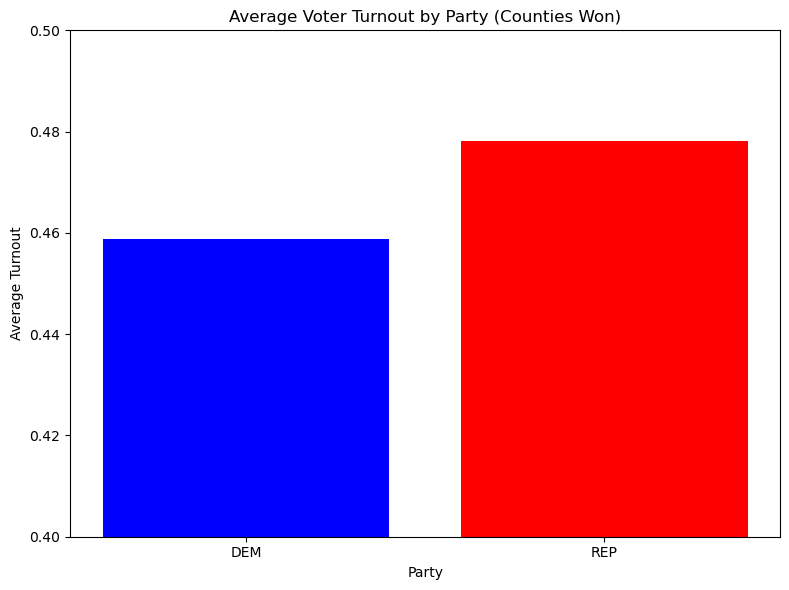

In [11]:
#bar chart of average turnout for rep wins vs dem wins
avg_turnout_by_party = pres_county.groupby('party').apply(lambda x: np.average(x['turnout'], weights=x['population']))

plt.figure(figsize=(8, 6))
plt.bar(avg_turnout_by_party.index, avg_turnout_by_party.values, color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Average Turnout')
plt.title('Average Voter Turnout by Party (Counties Won)')
plt.ylim(0.4, 0.5)
plt.tight_layout()
plt.show()

In [12]:
pres_county['margin_of_victory'] = pres_county['vote_share'] - (1-pres_county['vote_share'])
dem_data = pres_county[pres_county['party'] == 'DEM']
rep_data = pres_county[pres_county['party'] == 'REP']

In [13]:
sampled_data = pres_county.sample(n=500, random_state=26)
dem_data = sampled_data[sampled_data['party'] == 'DEM']
rep_data = sampled_data[sampled_data['party'] == 'REP']

Figure 3. Voter Turnout vs. County Population (Presidential Elections)

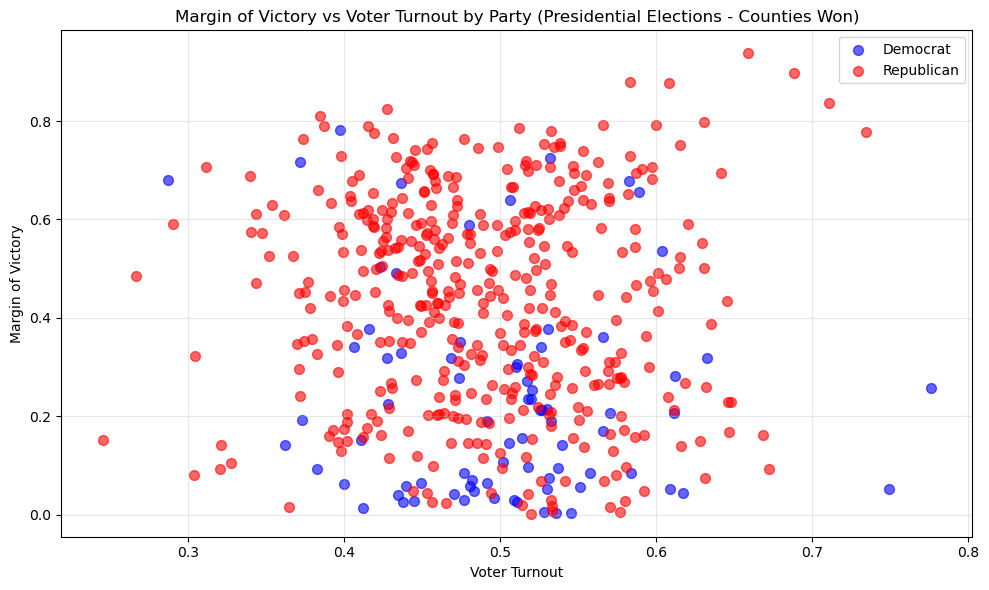

In [14]:
plt.figure(figsize=(10, 6))

plt.scatter(dem_data['turnout'], dem_data['margin_of_victory'], c='blue', label='Democrat', alpha=0.6, s=50)
plt.scatter(rep_data['turnout'], rep_data['margin_of_victory'], c='red', label='Republican', alpha=0.6, s=50)

plt.xlabel('Voter Turnout')
plt.ylabel('Margin of Victory')
plt.title('Margin of Victory vs Voter Turnout by Party (Presidential Elections - Counties Won)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Fig. 4 Margin of Victory vs. Voter Turnout by Party (Presidential Elections – Counties Won)

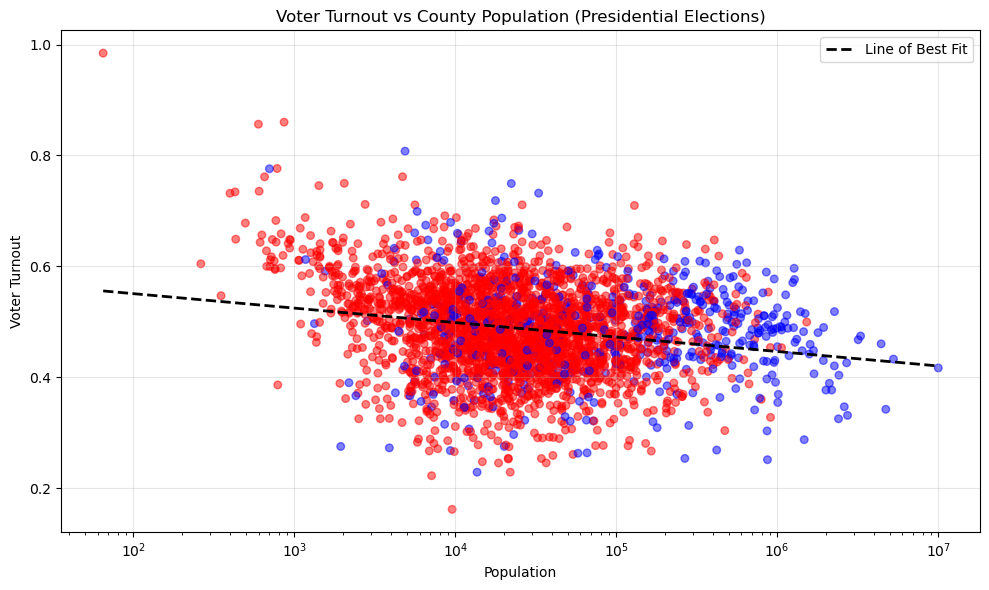

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(pres_county['population'], pres_county['turnout'], c=pres_county['party'].map({'DEM': 'blue', 'REP': 'red'}), alpha=0.5, s=30)
log_pop = np.log10(pres_county['population'])

#line of best fit
coefficients = np.polyfit(log_pop, pres_county['turnout'], 1)
poly = np.poly1d(coefficients)
x_line = np.linspace(log_pop.min(), log_pop.max(), 100)
y_line = poly(x_line)

plt.plot(10**x_line, y_line, color='black', linestyle='--', linewidth=2, label='Line of Best Fit')
plt.xlabel('Population')
plt.ylabel('Voter Turnout')
plt.title('Voter Turnout vs County Population (Presidential Elections)')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Senate Vote Share

In [28]:
senate_county_candidate = senate_county_candidate[(senate_county_candidate['party'] == 'REP') | (senate_county_candidate['party'] == 'DEM')]
vote_state = senate_county_candidate.groupby(['state', 'party'])['total_votes'].sum().reset_index()
vote_state = vote_state.rename(columns={'total_votes': 'candidate_votes'})

vote_state = vote_state.merge(senate_state, how='right', on=['state'])
vote_state = vote_state.merge(state_pop, how='right', on=['state'])

vote_state['vote_share'] = round(vote_state['candidate_votes'] / vote_state['total_votes'], 3)
vote_state = vote_state.dropna()
vote_state = vote_state.drop_duplicates(subset="state")


In [29]:
vote_state['turn_out'] = round(vote_state['total_votes'] / vote_state['population'], 3)

In [36]:
vote_state.describe()

,candidate_votes,total_votes,population,vote_share,turn_out
count,3.400000e+01,3.400000e+01,3.400000e+01,34.000000,34.000000
mean,4.456893e+05,2.483340e+06,5.267754e+06,0.190765,0.484647
std,4.598469e+05,2.263813e+06,5.387567e+06,0.091634,0.053457
min,1.002200e+04,2.708660e+05,5.768510e+05,0.020000,0.382000
25%,1.379692e+05,8.290938e+05,1.805064e+06,0.112500,0.452750
50%,2.925780e+05,1.871080e+06,4.098304e+06,0.213500,0.474000
75%,5.664512e+05,3.325402e+06,7.000148e+06,0.244750,0.520500
max,2.002904e+06,1.114404e+07,2.914550e+07,0.369000,0.601000


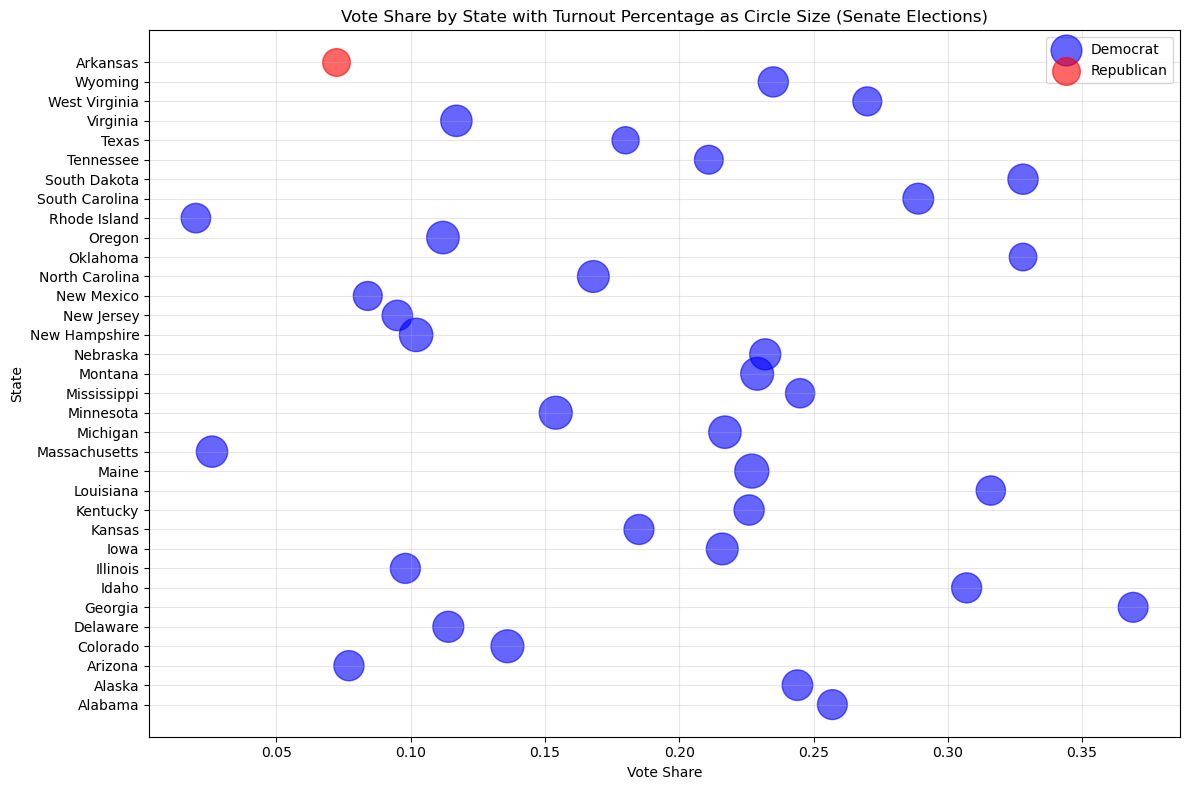

In [31]:
plt.figure(figsize=(12, 8))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

dem_sizes = dem_data['turn_out'] * 1000
rep_sizes = rep_data['turn_out'] * 1000

plt.scatter(dem_data['vote_share'], dem_data['state'], s=dem_sizes, c='blue', alpha=0.6, label='Democrat')
plt.scatter(rep_data['vote_share'], rep_data['state'], s=rep_sizes, c='red', alpha=0.6, label='Republican')

plt.xlabel('Vote Share')
plt.ylabel('State')
plt.title('Vote Share by State with Turnout Percentage as Circle Size (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

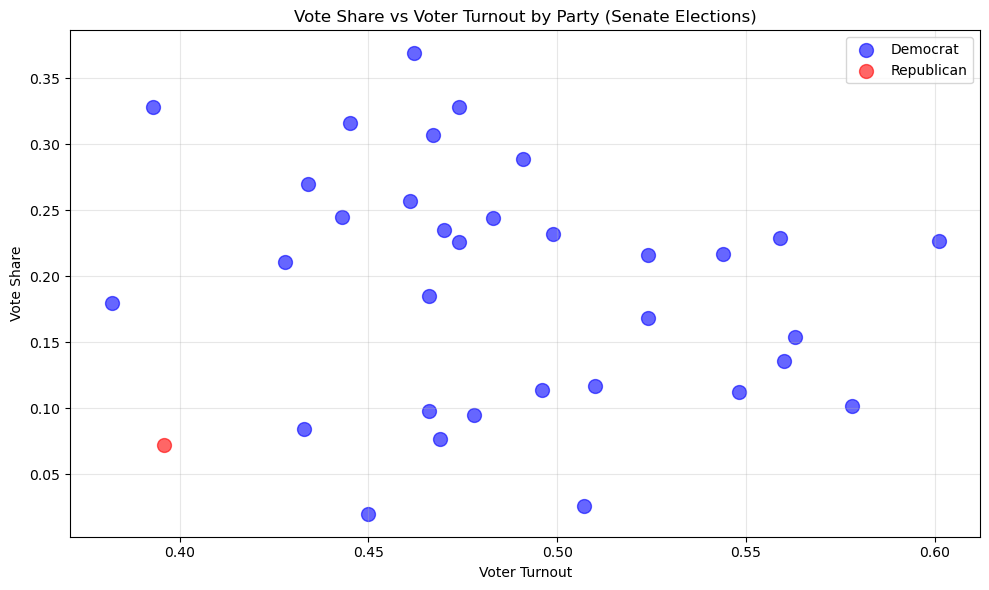

In [32]:
#scatter plot for vote share and turn out, color of the dot depends on party
plt.figure(figsize=(10, 6))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

plt.scatter(dem_data['turn_out'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turn_out'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Vote Share vs Voter Turnout by Party (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
vote_state = vote_state.loc[vote_state.groupby(['state'])['vote_share'].idxmax()]

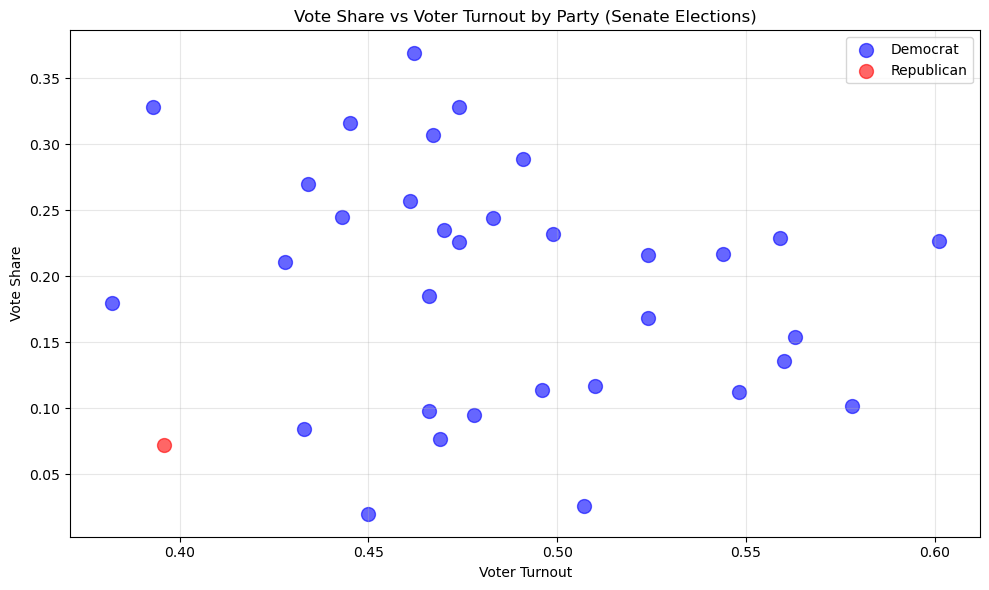

In [34]:
plt.figure(figsize=(10, 6))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

plt.scatter(dem_data['turn_out'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turn_out'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Vote Share vs Voter Turnout by Party (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

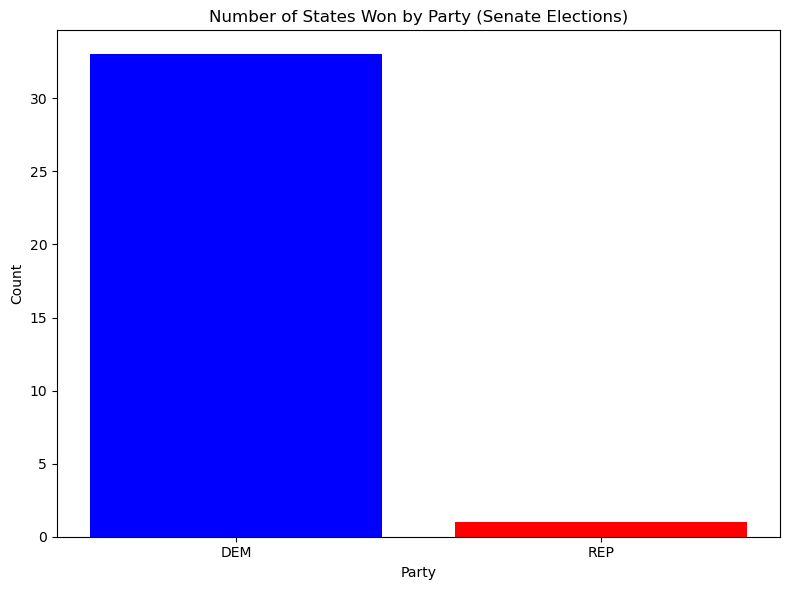

In [35]:
party_counts = vote_state['party'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(party_counts.index, party_counts.values, color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Count')
plt.title('Number of States Won by Party (Senate Elections)')
plt.tight_layout()
plt.show()